# Walkthrough: Computing SVD via Eigen-Decomposition

Below is a step-by-step explanation of what each part of the code is doing and why it works.

---

## 0) Goal and Key Idea

We want the SVD of a real matrix $A \in \mathbb{R}^{m\times n}:$
$$A = U\,\Sigma\,V^\top,$$
where:
- $U \in \mathbb{R}^{m\times m}$ has orthonormal columns (left singular vectors),
- $V \in \mathbb{R}^{n\times n}$ has orthonormal columns (right singular vectors),
- $\Sigma$ is diagonal with non-negative singular values.


## 1) Eigen-decomposition of $A^\top A$


- Form the symmetric, positive semidefinite matrix $A^\top A \in \mathbb{R}^{n\times n}$.
- Compute its eigenvalues (`eigvals`) and eigenvectors (`V`).
  - Columns of `V` are eigenvectors.
  - For exact arithmetic, all eigenvalues are $\ge 0$. Numerically, tiny negatives can occur.



## 2) Sort eigenpairs by descending eigenvalue

- SVD convention orders singular values from largest to smallest.
- We reorder eigenvalues and their eigenvectors accordingly.



## 3) Singular values = sqrt of eigenvalues (clipped)


- Convert eigenvalues to singular values: $\sigma_i = \sqrt{\max(\lambda_i, 0)}$.
- `np.clip` guards against tiny negative values due to floating-point error.



## 4) Compute left singular vectors \(U\)

- Using the relation $u_i = \frac{A v_i}{\sigma_i}$ when $\sigma_i \neq 0$.
- We skip division for effectively zero singular values (rank-deficient directions).


## 5) Orthonormalize/normalize columns of \(U\)


- Normalizes each nonzero column to unit length.
- The tiny $`1e-15`$ prevents divide-by-zero.

> **Note:** For perfectly computed $U$, normalization would be redundant; numerically it helps keep columns unit-norm.



## 7) Return $U$, $\Sigma$, $V^\top$

- The function returns:
  - `U` (left singular vectors, as columns),
  - `singular_vals` (the diagonal of $\Sigma$),
  - `V.T` (transpose of right singular vectors).



In [14]:
!pip install opencv-python

In [24]:
import numpy as np

def svd_via_eig(A):
    """
    Compute the Singular Value Decomposition (SVD) of matrix A
    using eigen-decomposition: A = U Σ V^T
    """
    # Ensure A is float (important for numerical stability)
    A = np.array(A, dtype=float)

    # ----------------------------
    # Step 1: Compute eigen-decomposition of A^T A
    # ----------------------------
    AtA = A.T @ A
    eigvals, V = np.linalg.eig(AtA)
    # ----------------------------
    # Implementation Ends Here
    # ----------------------------

    # Step 2: Sort eigenvalues and eigenvectors in descending order
    sort_idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[sort_idx]
    V = V[:, sort_idx]

    # Step 3: Singular values are sqrt of eigenvalues (non-negative)
    singular_vals = np.sqrt(np.clip(eigvals, 0, None))

    # Step 4: Compute U = A V / Σ
    U = np.zeros((A.shape[0], V.shape[1]))
    for i in range(len(singular_vals)):
        if singular_vals[i] > 1e-12:  # Avoid division by zero
            U[:, i] = (A @ V[:, i]) / singular_vals[i]

    # Step 5: Ensure orthonormality (normalize columns of U)
    for i in range(U.shape[1]):
        norm = np.linalg.norm(U[:, i]) + 1e-15
        U[:, i] /= norm

    # Step 6: Return U, Σ, V^T
    return U, singular_vals, V.T

# Example usage:
A = np.array([[3., 1., 1.],
              [-1., 3., 1.],
              [2., 2., 0.]])

U, S, Vt = svd_via_eig(A)

print("U =\n", U)
print("Singular values =", S)
print("V^T =\n", Vt)

# Verify reconstruction
A_recon = U @ np.diag(S) @ Vt
print("Reconstruction error:", np.linalg.norm(A - A_recon))


U =
 [[ 0.67121386  0.46028211  0.58104418]
 [ 0.39435899 -0.88545482  0.24586735]
 [ 0.62765671  0.06411043 -0.77584593]]
Singular values = [4.36673634 3.19226543 0.86084563]
V^T =
 [[ 0.65829392  0.71211175  0.24402042]
 [ 0.75010116 -0.64777241 -0.13318839]
 [-0.06322468 -0.27071711  0.96058049]]
Reconstruction error: 7.652133485838011e-15


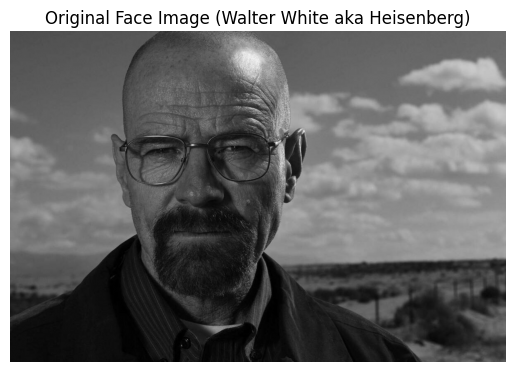

In [25]:
import cv2
import matplotlib.pyplot as plt

def load_image(image_path):
    """Load image in grayscale"""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Could not read image at path: {image_path}")
    return img

image_path = "face.png"
img = load_image(image_path)

# Display the original image
plt.imshow(img, cmap="gray")
plt.title("Original Face Image (Walter White aka Heisenberg)")
plt.axis("off")
plt.show()


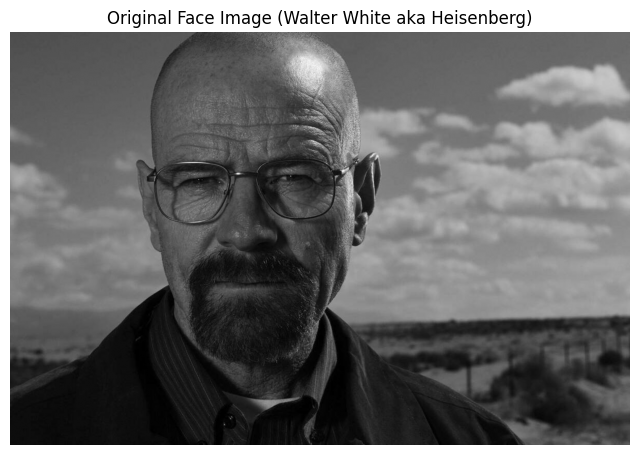

Image shape: (800, 1200)
Image dtype: uint8
Original size: 960000 pixels
Compressed representation size: 100050 parameters
Compression ratio: 9.60:1


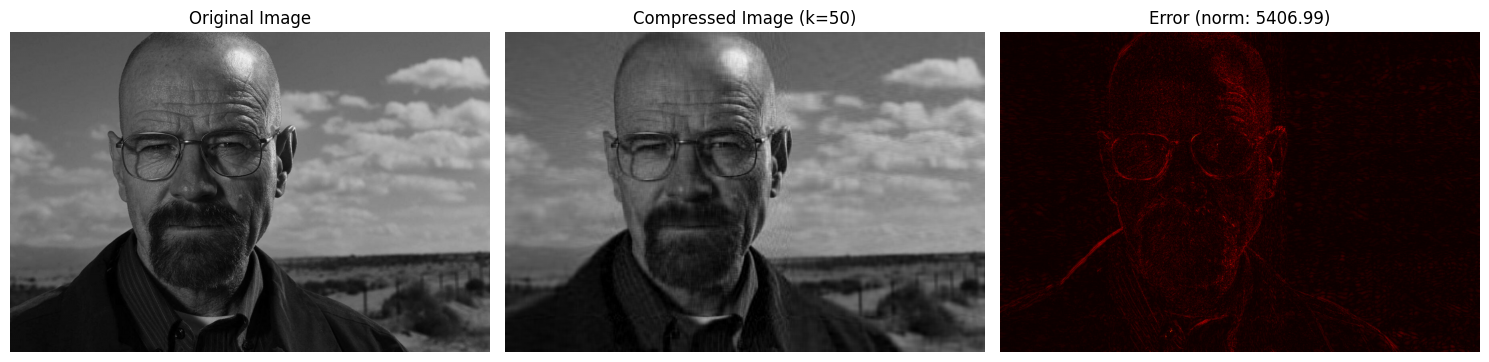

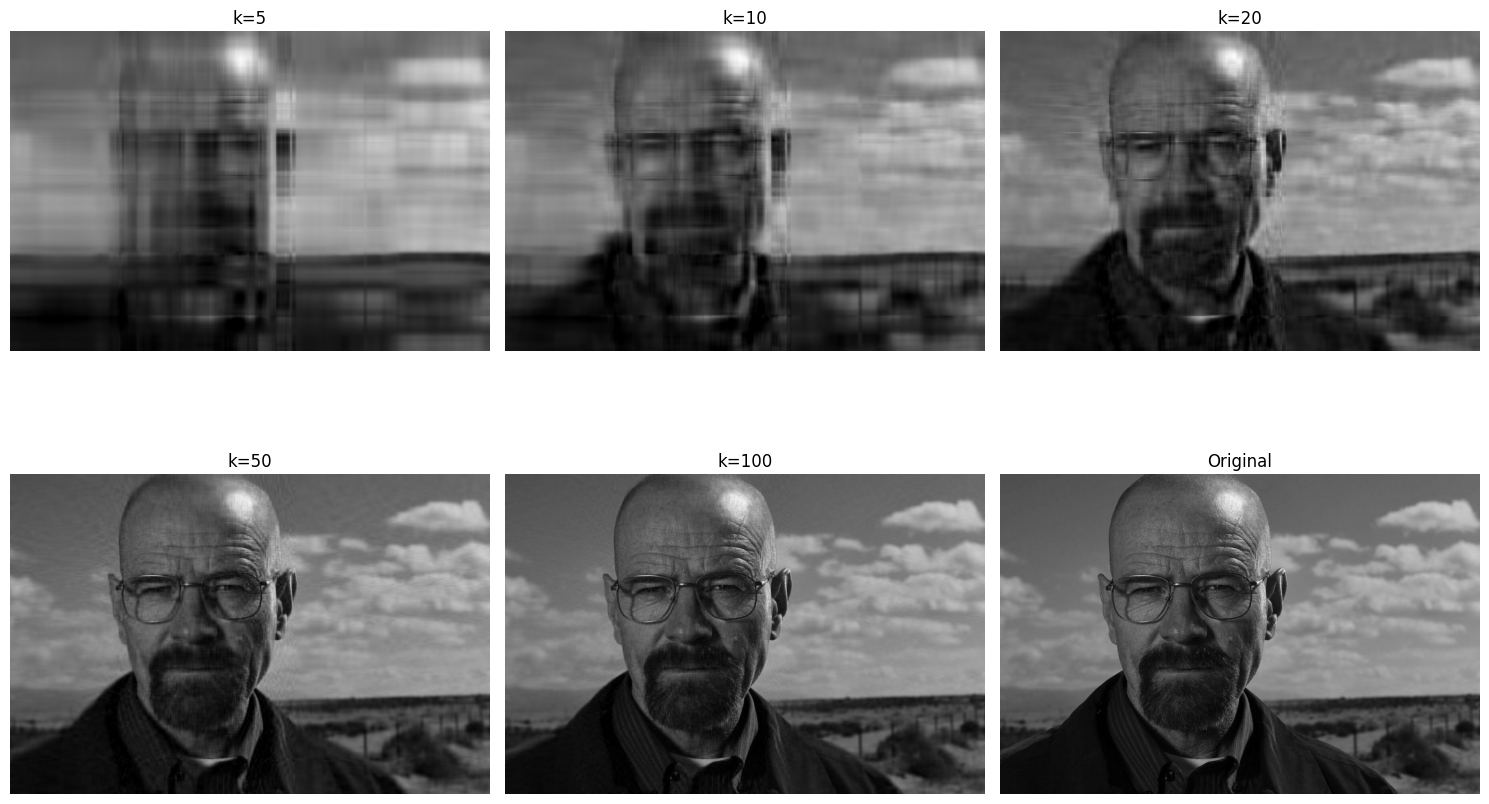

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_image(image_path):
    """Load image in grayscale"""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Could not read image at path: {image_path}")
    return img

# Load the actual image
image_path = "face.png"
img = load_image(image_path)

# Display the original image
plt.figure(figsize=(8, 6))
plt.imshow(img, cmap="gray")
plt.title("Original Face Image (Walter White aka Heisenberg)")
plt.axis("off")
plt.show()

def compress_image_svd(img, k):
    """Compress an image using SVD by keeping only k singular values"""
    # Ensure the image is 2D and convert to float for SVD
    img_float = img.astype(float)

    # ----------------------------
    # TODO Step 1: Compute full SVD using numpy's SVD
    # U: Left Singular Vectors. S: Singular Values. Vt: Right Singular Vectors Transposed.
    # Set full_matrices=False for efficiency.
    # ----------------------------
    U, S, Vt = np.linalg.svd(img_float, full_matrices=False)
    # ----------------------------
    # Implementation Ends Here
    # ----------------------------

    # Step 2: Keep only top-k singular values
    # More efficient approach without creating full diagonal matrix
    U_k = U[:, :k]  # Take first k columns of U
    S_k = S[:k]     # Take first k singular values
    Vt_k = Vt[:k, :]  # Take first k rows of Vt

    # TODO Step 3: Reconstruct the image using U dot S dot V^T
    # Use efficient multiplication: U_k @ diag(S_k) @ Vt_k
    compressed_img = U_k @ np.diag(S_k) @ Vt_k
    # ----------------------------
    # Implementation Ends Here
    # ----------------------------

    return np.clip(compressed_img, 0, 255).astype(np.uint8)  # Clip to valid pixel range

print(f"Image shape: {img.shape}")
print(f"Image dtype: {img.dtype}")

# ----------------------------
# TODO Compress image using SVD utilizing compress_image_svd with k=50
# ----------------------------
k = 50
compressed_img = compress_image_svd(img, k)
# ----------------------------
# Implementation Ends Here
# ----------------------------

# Calculate compression statistics
original_size = img.shape[0] * img.shape[1]
compressed_size = k * (img.shape[0] + img.shape[1] + 1)  # k*(m + n + 1)
compression_ratio = original_size / compressed_size

print(f"Original size: {original_size} pixels")
print(f"Compressed representation size: {compressed_size} parameters")
print(f"Compression ratio: {compression_ratio:.2f}:1")

# Display Results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(compressed_img, cmap="gray")
plt.title(f"Compressed Image (k={k})")
plt.axis("off")

# Calculate reconstruction error
error = np.linalg.norm(img.astype(float) - compressed_img.astype(float))
plt.subplot(1, 3, 3)
plt.imshow(np.abs(img.astype(float) - compressed_img.astype(float)), cmap="hot")
plt.title(f"Error (norm: {error:.2f})")
plt.axis("off")

plt.tight_layout()
plt.show()

# Test different compression levels
plt.figure(figsize=(15, 10))

k_values = [5, 10, 20, 50, 100]
for i, k_val in enumerate(k_values):
    compressed = compress_image_svd(img, k_val)

    plt.subplot(2, 3, i+1)
    plt.imshow(compressed, cmap="gray")
    plt.title(f"k={k_val}")
    plt.axis("off")

plt.subplot(2, 3, 6)
plt.imshow(img, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.tight_layout()
plt.show()

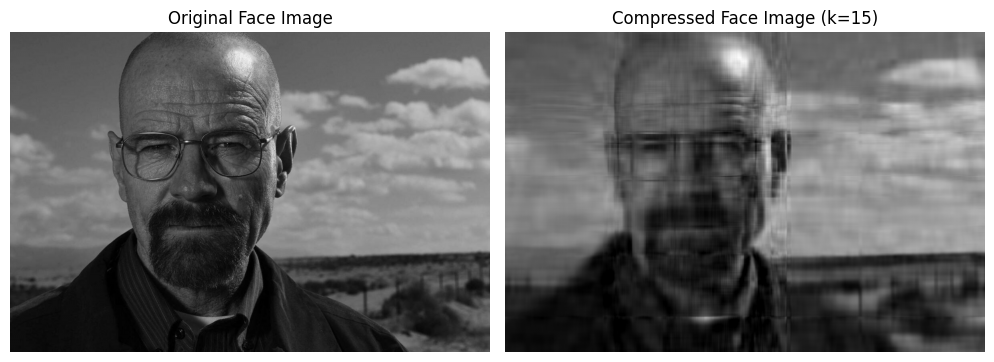

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_image(image_path):
    """Load image in grayscale"""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Could not read image at path: {image_path}")
    return img

def compress_image_svd(img, k):
    """Compress an image using SVD by keeping only k singular values"""
    # Ensure the image is 2D and convert to float for SVD
    img_float = img.astype(float)

    # Compute full SVD using numpy's SVD
    U, S, Vt = np.linalg.svd(img_float, full_matrices=False)

    # Keep only top-k singular values
    U_k = U[:, :k]  # Take first k columns of U
    S_k = S[:k]     # Take first k singular values
    Vt_k = Vt[:k, :]  # Take first k rows of Vt

    # Reconstruct the image using U dot S dot V^T
    compressed_img = U_k @ np.diag(S_k) @ Vt_k

    return np.clip(compressed_img, 0, 255).astype(np.uint8)

# Load the actual image
image_path = "face.png"
img = load_image(image_path)

# ----------------------------
# TODO Compress image using SVD utilizing compress_image_svd with k=15
# ----------------------------
k = 15
compressed_img = compress_image_svd(img, k)
# ----------------------------
# Implementation Ends Here
# ----------------------------

# Display Results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap="gray")
plt.title("Original Face Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(compressed_img, cmap="gray")
plt.title(f"Compressed Face Image (k={k})")
plt.axis("off")

plt.tight_layout()
plt.show()

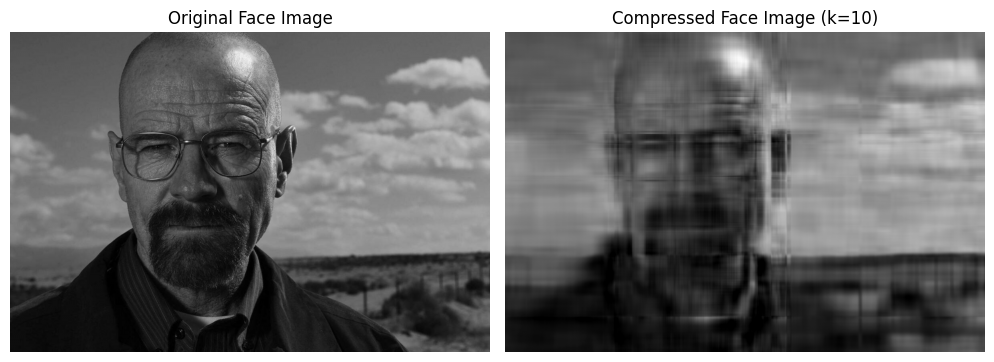

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_image(image_path):
    """Load image in grayscale"""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Could not read image at path: {image_path}")
    return img

def compress_image_svd(img, k):
    """Compress an image using SVD by keeping only k singular values"""
    # Ensure the image is 2D and convert to float for SVD
    img_float = img.astype(float)

    # Compute full SVD using numpy's SVD
    U, S, Vt = np.linalg.svd(img_float, full_matrices=False)

    # Keep only top-k singular values
    U_k = U[:, :k]  # Take first k columns of U
    S_k = S[:k]     # Take first k singular values
    Vt_k = Vt[:k, :]  # Take first k rows of Vt

    # Reconstruct the image using U dot S dot V^T
    compressed_img = U_k @ np.diag(S_k) @ Vt_k

    return np.clip(compressed_img, 0, 255).astype(np.uint8)

# Load the actual image
image_path = "face.png"
img = load_image(image_path)

# ----------------------------
# TODO Compress image using SVD utilizing compress_image_svd with k=10
# ----------------------------
k = 10
compressed_img = compress_image_svd(img, k)
# ----------------------------
# Implementation Ends Here
# ----------------------------

# Display Results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap="gray")
plt.title("Original Face Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(compressed_img, cmap="gray")
plt.title(f"Compressed Face Image (k={k})")
plt.axis("off")

plt.tight_layout()
plt.show()

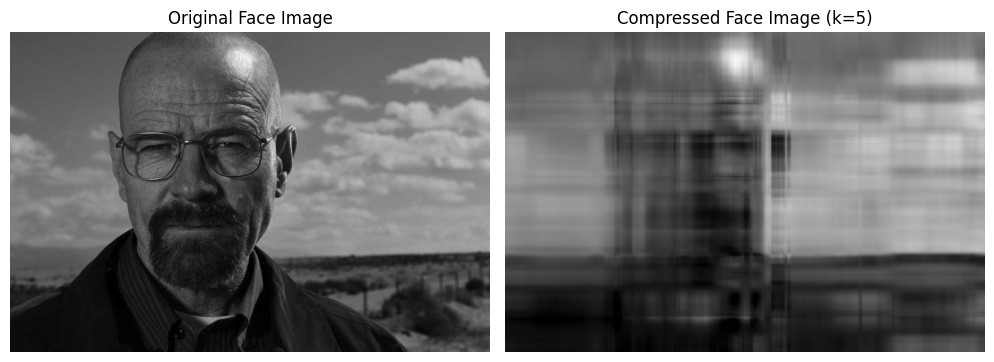

In [30]:
# ----------------------------
# TODO Compress image using SVD utilizing compress_image_svd with k=5
# ----------------------------
k = 5
compressed_img = compress_image_svd(img, k)
# ----------------------------
# Implementation Ends Here
# ----------------------------

# Display Results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap="gray")
plt.title("Original Face Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(compressed_img, cmap="gray")
plt.title(f"Compressed Face Image (k={k})")
plt.axis("off")

plt.tight_layout()
plt.show()


**Goal:** Compare **TF–IDF → KNN** vs **TF–IDF → TruncatedSVD (LSA) → KNN** for **binary sentiment** classification on IMDB reviews.

You will:
- Load IMDB reviews with text and labels.
- Build a TF–IDF → KNN baseline (sweep `k`, metric, weights).
- Add Truncated SVD (LSA) → KNN and choose `k_svd` + `n_neighbors` with validation F1.
- Evaluate on a held-out test set and discuss trade-offs.

> ✅ **Deliverables**: code, plots, final metrics table, and a short written analysis.



## 0) Setup

- Recommended: Python 3.9+  
- Install dependencies if needed.

> If `datasets` is not installed, uncomment the first line below.


In [ ]:

# !pip install numpy pandas scikit-learn matplotlib datasets
import os, sys, math, json, random, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)



## 1) Load IMDB & Create Splits


In [23]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

# Load IMDB
ds = load_dataset("imdb")
train_text = ds["train"]["text"]
train_label = ds["train"]["label"]
test_text  = ds["test"]["text"]
test_label = ds["test"]["label"]

train_text = list(ds["train"]["text"])
train_label = list(ds["train"]["label"])

# Set random state for reproducibility
RANDOMSTATE = 42

# ----------------------------
# TODO Create the train/validation train using the train_test_split method from sklearn where  X=train_test, y=train_label, test_size=0.2, random_state=RANDOMSTATE and stratify=train_label
# ----------------------------
X_train, X_val, y_train, y_val = train_test_split(
    train_text, train_label, test_size=0.2, random_state=RANDOMSTATE, stratify=train_label
)
# ----------------------------
# Implementation Ends Here
# ----------------------------

X_test, y_test = test_text, test_label
print(f"Train: {len(X_train)}  |  Val: {len(X_val)}  |  Test: {len(X_test)}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Train: 20000  |  Val: 5000  |  Test: 25000



> **Fallback (optional): CSV Loader** – If you can’t use `datasets`, put a CSV with `text` and `label` (0/1) and run this instead.


In [32]:
print(np.unique(y_train))
# Get unique values and their counts
unique_values, counts = np.unique(y_train, return_counts=True)

# Print the unique values and their counts
print("Unique values:", unique_values)
print("Counts:", counts)

[0 1]
Unique values: [0 1]
Counts: [10000 10000]


In [33]:
for pos_text,text_value in enumerate(X_train[:5]):
  print(text_value[:120],y_train[pos_text])

I have always been a huge James Bond fanatic! I have seen almost all of the films except for Die Another Day, and The Wo 1
I am a Christian and I say this movie had terrible acting, unreal situations and a completely facade front for Christian 0
Neatly sandwiched between THE STRANGER, a small film noir picture that proved Welles can do a formidable genre work on b 1
Years ago I did follow a soap on TV. So I was curious about this movie, and I was so rewarded for finding it. It's a mar 1
Here's a gritty, get-the-bad guys revenge story starring a relentless and rough Denzel Washington. He's three personalit 1



## 2) Baseline: TF–IDF → KNN


## 📘 What is TF-IDF?

**TF-IDF** stands for **Term Frequency – Inverse Document Frequency**.  
It is a numerical statistic used to reflect **how important a word is** to a document within a collection (called the *corpus*).

Formally, it combines two ideas:

$$\text{TF–IDF}(t, d) = \text{TF}(t, d) \times \text{IDF}(t)$$

where  
- \(t\) = term (word)  
- \(d\) = one document  
- the corpus = all documents  

<br><br><br><br>

**Term Frequency** measures how often a word appears in a specific document.

$$\text{TF}(t, d) = \frac{\text{count of term } t \text{ in document } d}{\text{total number of terms in } d}$$

TF is higher when the term occurs more frequently in the document.
  
<br><br><br><br>

**Inverse Document Frequency** measures how *rare* or *unique* a word is across the entire corpus.

$\text{IDF}(t) = \log\left(\frac{N}{1 + n_t}\right)$

where  
- \(N\) = total number of documents  
- \(n_t\) = number of documents containing the term \(t\)

Intuitively:
- Common words like “the”, “and”, or “is” appear in many documents → **low IDF**
- Rare or discriminative words like “thriller”, “blockchain” → **high IDF**

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report
import time
import pandas as pd

k_nn_list_vals = [2,5]

tfidf = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    ngram_range=(1,2),
    max_df=0.9,
    min_df=5
)

def eval_knn(model, name, X_tr, y_tr, X_va, y_va):
    # ----------------------------
    # TODO use the KNN model and fit it to the X_tr using the y_tr labels
    # ----------------------------
    t0 = time.time()
    model.fit(X_tr, y_tr)
    # ----------------------------
    # Implementation Ends Here
    # ----------------------------

    fit_s = time.time() - t0

    # ----------------------------
    #TODO now use the model to predict on the validation set (X_va) set
    # ----------------------------
    y_hat = model.predict(X_va)
    pred_s = time.time() - t0 - fit_s
    # ----------------------------
    # Implementation Ends Here
    # ----------------------------

    # ----------------------------
    #TODO calculate the accuracy_score and f1_score using sklearn.metrics
    # ----------------------------
    acc = accuracy_score(y_va, y_hat)
    f1  = f1_score(y_va, y_hat)
    # ----------------------------
    # Implementation Ends Here
    # ----------------------------

    print(f"\n=== {name} (VAL) ===")
    print("Accuracy:", round(acc,4), " F1:", round(f1,4), f"| fit {fit_s:.2f}s, pred {pred_s:.2f}s")
    print(classification_report(y_va, y_hat, digits=4))
    return acc, f1

baseline_results = []
for metric in ["cosine", "euclidean"]:
    for k in k_nn_list_vals:
        for w in ["uniform", "distance"]:
            pipe = Pipeline([
                ("tfidf", tfidf),
                ("knn", KNeighborsClassifier(n_neighbors=k, metric=metric, weights=w))
            ])
            acc, f1 = eval_knn(pipe, f"TFIDF+KNN | k={k} | {metric} | {w}",
                               X_train, y_train, X_val, y_val)
            baseline_results.append(dict(model="TFIDF+KNN", k=k, metric=metric, weights=w, acc=acc, f1=f1))

baseline_df = pd.DataFrame(baseline_results).sort_values(["metric","k","weights"]).reset_index(drop=True)
baseline_df.head()


=== TFIDF+KNN | k=2 | cosine | uniform (VAL) ===
Accuracy: 0.7348  F1: 0.6984 | fit 8.46s, pred 8.29s
              precision    recall  f1-score   support

           0     0.6891    0.8556    0.7634      2500
           1     0.8096    0.6140    0.6984      2500

    accuracy                         0.7348      5000
   macro avg     0.7494    0.7348    0.7309      5000
weighted avg     0.7494    0.7348    0.7309      5000


=== TFIDF+KNN | k=2 | cosine | distance (VAL) ===
Accuracy: 0.7322  F1: 0.7426 | fit 7.44s, pred 8.17s
              precision    recall  f1-score   support

           0     0.7527    0.6916    0.7209      2500
           1     0.7148    0.7728    0.7426      2500

    accuracy                         0.7322      5000
   macro avg     0.7337    0.7322    0.7318      5000
weighted avg     0.7337    0.7322    0.7318      5000


=== TFIDF+KNN | k=5 | cosine | uniform (VAL) ===
Accuracy: 0.761  F1: 0.7653 | fit 8.09s, pred 8.27s
              precision    recall  f1

,model,k,metric,weights,acc,f1
0,TFIDF+KNN,2,cosine,distance,0.7322,0.742648
1,TFIDF+KNN,2,cosine,uniform,0.7348,0.698362
2,TFIDF+KNN,5,cosine,distance,0.7628,0.766994
3,TFIDF+KNN,5,cosine,uniform,0.7610,0.765272
4,TFIDF+KNN,2,euclidean,distance,0.7322,0.742648



## 3) Truncated SVD (LSA) → KNN


In [45]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

# Define the random state for reproducibility
RANDOM_STATE = 42

def make_svd_knn(k_components, n_neighbors, metric="cosine", weights="distance"):
    return Pipeline([
        ("tfidf", tfidf),
        # ----------------------------
        #TODO use TruncatedSVD where the n_components=k_components, random_state=RANDOM_STATE
        # ----------------------------
        ("svd", TruncatedSVD(n_components=k_components, random_state=RANDOM_STATE)),
        # ----------------------------
        # Implementation Ends Here
        # ----------------------------
        ("norm", Normalizer(norm="l2")),
        ("knn", KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric, weights=weights))
    ])

rows = []
k_svd_list = [50]

for k_svd in k_svd_list:
    for k_nn in k_nn_list_vals:
        for metric in ["cosine", "euclidean"]:
            for w in ["uniform", "distance"]:
                pipe = make_svd_knn(k_svd, k_nn, metric=metric, weights=w)
                pipe.fit(X_train, y_train)
                y_val_hat = pipe.predict(X_val)
                acc = accuracy_score(y_val, y_val_hat)
                f1  = f1_score(y_val, y_val_hat)
                evr = pipe.named_steps["svd"].explained_variance_ratio_.sum()
                rows.append({"k_svd": k_svd, "k_nn": k_nn, "metric": metric, "weights": w,
                             "acc": acc, "f1": f1, "evr": evr})

svd_df = pd.DataFrame(rows).sort_values(["k_svd","k_nn","metric","weights"]).reset_index(drop=True)
svd_df.head()

,k_svd,k_nn,metric,weights,acc,f1,evr
0,50,2,cosine,distance,0.7200,0.718310,0.048608
1,50,2,cosine,uniform,0.7032,0.640504,0.048608
2,50,2,euclidean,distance,0.7200,0.718310,0.048608
3,50,2,euclidean,uniform,0.7032,0.640504,0.048608
4,50,5,cosine,distance,0.7546,0.752970,0.048608


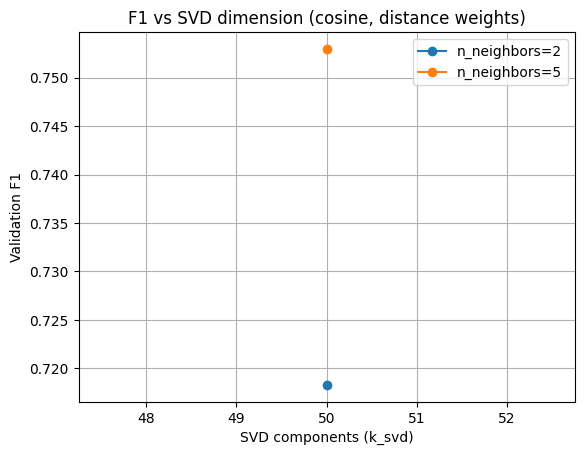

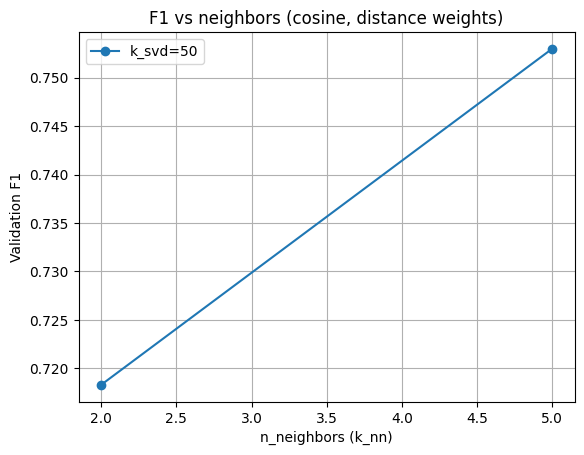

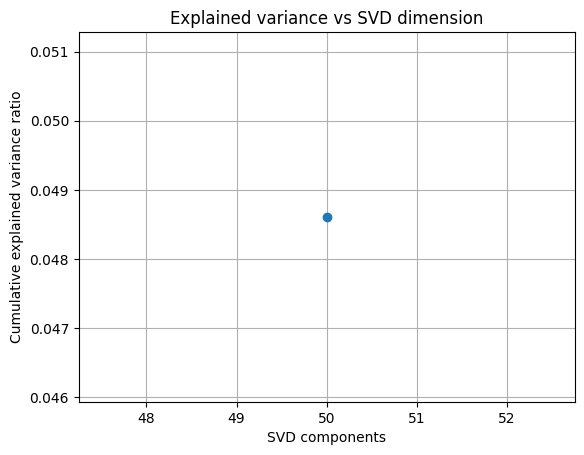

In [46]:

# Plots (matplotlib only; single charts, default colors)
sub = svd_df[(svd_df["metric"]=="cosine") & (svd_df["weights"]=="distance")]
plt.figure()
for k_nn in sorted(sub["k_nn"].unique()):
    s = sub[sub["k_nn"]==k_nn]
    plt.plot(s["k_svd"], s["f1"], marker="o", label=f"n_neighbors={k_nn}")
plt.xlabel("SVD components (k_svd)"); plt.ylabel("Validation F1")
plt.title("F1 vs SVD dimension (cosine, distance weights)"); plt.grid(True); plt.legend(); plt.show()

plt.figure()
for k_svd in sorted(sub["k_svd"].unique()):
    s = sub[sub["k_svd"]==k_svd]
    plt.plot(s["k_nn"], s["f1"], marker="o", label=f"k_svd={k_svd}")
plt.xlabel("n_neighbors (k_nn)"); plt.ylabel("Validation F1")
plt.title("F1 vs neighbors (cosine, distance weights)"); plt.grid(True); plt.legend(); plt.show()

evr_by_k = sub.groupby("k_svd")["evr"].mean()
plt.figure()
plt.plot(evr_by_k.index, evr_by_k.values, marker="o")
plt.xlabel("SVD components"); plt.ylabel("Cumulative explained variance ratio")
plt.title("Explained variance vs SVD dimension"); plt.grid(True); plt.show()



## 4) Final Selection & **Test** Evaluation


In [49]:

best = svd_df.sort_values("f1", ascending=False).iloc[0]
best


,4
k_svd,50
k_nn,5
metric,cosine
weights,distance
acc,0.7546
f1,0.75297
evr,0.048608


In [50]:
X_tr_final = np.concatenate([X_train])
y_tr_final = np.concatenate([y_train])

from sklearn.metrics import confusion_matrix

final_pipe = make_svd_knn(
    k_components=int(best["k_svd"]),
    n_neighbors=int(best["k_nn"]),
    metric=str(best["metric"]),
    weights=str(best["weights"])
)
final_pipe.fit(X_tr_final, y_tr_final)
y_test_hat = final_pipe.predict(X_test)

print("\n=== FINAL TEST RESULTS (SVD+KNN) ===")
print("Accuracy:", round(accuracy_score(y_test, y_test_hat), 4))
print("F1:", round(f1_score(y_test, y_test_hat), 4))
print(classification_report(y_test, y_test_hat, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_hat))



=== FINAL TEST RESULTS (SVD+KNN) ===
Accuracy: 0.7515
F1: 0.7423
              precision    recall  f1-score   support

           0     0.7347    0.7874    0.7601     12500
           1     0.7710    0.7156    0.7423     12500

    accuracy                         0.7515     25000
   macro avg     0.7528    0.7515    0.7512     25000
weighted avg     0.7528    0.7515    0.7512     25000

Confusion matrix:
 [[9843 2657]
 [3555 8945]]



## 5) Compare against **TF–IDF-only KNN**


In [51]:

# Pick best TFIDF baseline from baseline_df
best_base = baseline_df.sort_values("f1", ascending=False).iloc[0]
best_base

BEST_BASE_METRIC  = best_base["metric"]
BEST_BASE_K       = int(best_base["k"])
BEST_BASE_WEIGHTS = best_base["weights"]

tfidf_only_best = Pipeline([
    ("tfidf", tfidf),
    ("knn", KNeighborsClassifier(n_neighbors=BEST_BASE_K, metric=BEST_BASE_METRIC, weights=BEST_BASE_WEIGHTS))
])

tfidf_only_best.fit(X_tr_final, y_tr_final)
y_test_hat_base = tfidf_only_best.predict(X_test)

print(f"\n=== FINAL TEST RESULTS (TFIDF+KNN: k={BEST_BASE_K}, {BEST_BASE_METRIC}, {BEST_BASE_WEIGHTS}) ===")
print("Accuracy:", round(accuracy_score(y_test, y_test_hat_base), 4))
print("F1:", round(f1_score(y_test, y_test_hat_base), 4))
print(classification_report(y_test, y_test_hat_base, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_hat_base))



=== FINAL TEST RESULTS (TFIDF+KNN: k=5, cosine, distance) ===
Accuracy: 0.6344
F1: 0.5964
              precision    recall  f1-score   support

           0     0.6131    0.7286    0.6659     12500
           1     0.6656    0.5402    0.5964     12500

    accuracy                         0.6344     25000
   macro avg     0.6394    0.6344    0.6312     25000
weighted avg     0.6394    0.6344    0.6312     25000

Confusion matrix:
 [[9108 3392]
 [5747 6753]]



### ✅ Add this comparison table to your report

| Features           | Model | SVD k | kNN k | Metric   | Weights   | Test Acc | Test F1 | Notes                    |
|--------------------|-------|------:|------:|----------|-----------|---------:|--------:|--------------------------|
| TF–IDF             | KNN   |   —   |   7   | cosine   | distance  |    …     |    …    | sparse, high-dim         |
| TF–IDF → **SVD**   | KNN   |  200  |   7   | cosine   | distance  |    …     |    …    | dense, low-rank semantic |



## 6) - Misclassification analysis


In [52]:
# Show a few misclassified examples for error analysis

def show_examples(X_raw, y_true, y_pred, want=5, which="fp"):
    idxs = []
    all_correct_tp = []
    all_correct_tn = []
    for i, (yt, yp) in enumerate(zip(y_true, y_pred)):
        if which == "fp" and yt == 0 and yp == 1:
            idxs.append(i)
        if which == "fn" and yt == 1 and yp == 0:
            idxs.append(i)
        if yt == 1 and yp == 1:
          all_correct_tp.append(i)
        elif yt == 0 and yp == 0:
          all_correct_tn.append(i)
    idxs = idxs[:want]
    print(f"Correct positive predictions (TP): {len(all_correct_tp)}")
    print(f"Correct negative predictions (TN): {len(all_correct_tn)}")
    print(f"\nShowing {which.upper()} ({len(idxs)}):")
    for i in idxs:
        print(f"\n--- idx={i}  true={y_true[i]}  pred={y_pred[i]} ---")
        #print(X_raw[i][:500].replace(\"\\n\",\" \"))
        print(X_raw[i][:500])


# ----------------------------
# TODO: Use the SVD + KNN model we defined and predict on our validation set
#       show_examples will take the validation set with the corresponding X_val and y_val
#       along with your predictions
# ----------------------------
# Use the best SVD+KNN model from previous results
best_pipe = make_svd_knn(k_components=50, n_neighbors=5, metric="cosine", weights="distance")
best_pipe.fit(X_train, y_train)
y_val_hat_best = best_pipe.predict(X_val)

show_examples(X_val, y_val, y_val_hat_best, want=1, which="fp")
show_examples(X_val, y_val, y_val_hat_best, want=1, which="fn")
# ----------------------------
# Implementation Ends Here
# ----------------------------

Correct positive predictions (TP): 1870
Correct negative predictions (TN): 1903

Showing FP (1):

--- idx=63  true=0  pred=1 ---
This is exactly the sort of Saturday matinee serial I loved during World War II. I was under ten years of age. And that's the audience this serial is designed for. Looking at it now, one must roar at its ineptitude and stupidity. The budget must have been next to nothing, given the shortcuts and repeats. The acting? Well, this is Republic pictures, 1944. They read the lines....and no doubt had one take to make them convincing.<br /><br />One and half stars.
Correct positive predictions (TP): 1870
Correct negative predictions (TN): 1903

Showing FN (1):

--- idx=1  true=1  pred=0 ---
This is a must see for independant movie fans, but it also holds up well against mainstream movies. I think we have the makings of the next Woody Allen or<br /><br />Trentin Tarrentino here.<br /><br />The budget is painfully low. No special effects whatsoever, and they seemingly 

In [ ]:
print(y_val_hat_best[:10])
print(y_val[:10])
print(len(y_val))

# The next part of the lab will involve submitting to a Kaggle competition in prepartion for the mid-term

You can find the Kaggle competition at https://www.kaggle.com/competitions/cs-506-practice-compeition

1) First you will download the test_df.csv from the Kaggle compeition
2) You will use your best trained model to perform predictions on the test_df.csv
3) Submit the my_predictions.csv to the Kaggle competition
4) The train_df.csv on the Kaggle compeition is the same as the training data we used in this lab

In [57]:
text_values = []
numbers = []
with open('test_df.csv') as f:
  for pos_line,line in enumerate(f):
    if pos_line == 0:
      continue
    text_ = line.strip().split(',', 1)[1]
    nums = line.strip().split(',', 1)[0]
    #print(nums)
    text_values.append(text_)
    numbers.append(nums)
    #if pos_line == 1000:
    #  break

In [58]:
y_test_hat = final_pipe.predict(text_values)

In [59]:
data = {'id': numbers,'label': y_test_hat}
df = pd.DataFrame(data)
df.to_csv('my_prediction.csv',index=False)